# ゼロから始める簡単NNP

## NNPとは？？
Neural Network Potentialの略です。原子構造の情報を受け取って、エネルギーの値を予測する、ニューラルネットワークベースの機械学習モデルです。第一原理計算での構造とエネルギーの関係を再現するように、第一原理計算結果を使って学習させる仕組みを使っています。

この最も単純なケースを試してみましょう。今回扱うのは、結晶Siです。分子動力学法のトラジェクトリーを使って、様々な温度での熱ゆらぎが加わっていたり、密度が異なった状態での1250パターンの構造とエネルギーの情報を集めてあるので、それを学習データにします。

NNP stands for Neural Network Potential. It is a neural network-based machine learning model that receives information about atomic structure and predicts energy values. It uses a mechanism to train the model using ab initio results so that it replicates the relationship between structure and energy.

Let us try this simplest case. We will be dealing with crystalline Si. Using molecular dynamics trajectories, we have collected information on the structure and energy of 1250 patterns at various temperatures with added thermal fluctuations and different densities, which we will use as training data.

## 対称性関数の計算結果のロード
構造とエネルギーの関係を学ばせるにあたって、まず構造をニューラルネットワーク的に扱いやすいデータに変換する必要があります。
その方法の一つが対称性関数です。

対称性関数の説明や計算は別のファイルにまとめているので、そちらを見てください。
https://github.com/eminamitani/sample_NNP/blob/main/make_desc.ipynb

今回は時間短縮のため保存しておいたデータを使います。

In order for students to learn the relationship between structure and energy, it is first necessary to convert the structure into data that is easy to handle in a neural network manner.
One of the methods is the symmetry function.

The explanation and calculation of the symmetry function are summarized in another file.
https://github.com/eminamitani/sample_NNP/blob/main/make_desc.ipynb

This time we will use the data we have saved to save time.

In [1]:
import numpy as np
desc=np.load('desc.npy')
label=np.load('label.npy')

In [2]:
desc.shape

(1250, 64, 11)

データがどんな形か確認してみましょう。descは計算された対称性関数の11の値（最初の値は、G0と表記されるシンプルな動径分布に対応します）を保持していて、labelは系の原子あたりの平均エネルギーの情報を持っています。(全エネルギーそのままだと値が大きすぎるので)

Let's see what the data looks like: desc holds the 11 values of the calculated symmetry function (the first value corresponds to a simple radial distribution, denoted G0), and label holds information on the average energy per atom of the system. (The values are too large if the total energy is kept as it is.)

In [3]:
desc[0,0,:], label[0]

(array([13.571609  ,  9.172703  ,  6.4423614 ,  3.4930756 ,  1.3537661 ,
         0.35307807,  0.03834928,  0.7360559 ,  0.43611127,  0.28210217,
         0.05149077], dtype=float32),
 -5.8122244)

In [4]:
desc[1,0,:], label[1]

(array([14.427327  ,  9.910984  ,  7.078461  ,  3.9639223 ,  1.6263943 ,
         0.4749474 ,  0.06694016,  1.0451641 ,  0.593504  ,  0.4443306 ,
         0.08542389], dtype=float32),
 -5.812823)

対称性関数の値にもそれなりにばらつきがありそうです。

ニューラルネットワークの実装では配列の形を勘違いしてミスをすることが多いので確認しておきます

In [5]:
desc.shape, label.shape

((1250, 64, 11), (1250,))

本当はデータを正規化したほうが良いのですが、ひとまず単純に処理してみましょう

 ## ニューラルネットワークの定義
 今回は、ニューラルネットワークというと真っ先にイメージされる多層パーセプトロンを使います。

 このモデルでは、11の対称性関数の値を受け取って、それをノード数20の隠れ層に渡し、最終的に一つの出力を得る形になっています。
 この出力は「原子ひとつあたりのエネルギー」に相当すると考えます。原子ひとつあたりのエネルギーが物理的にきちんと定義できるのかはさておき、それらを足し上げると、系の全エネルギーになるようにネットワーク中の重みやバイアスを最適化していきます。

 In this case, we will use a multilayer perceptron, which is the first thing you think of when you think of neural networks.

 In this model, we take the values of 11 symmetry functions and pass them to a hidden layer with 20 nodes to obtain one final output.
 This output corresponds to "energy per atom. We will optimize the weights and biases in the network so that the total energy of the system is obtained by adding up the energy per atom, regardless of whether the energy per atom can be properly defined physically.

In [6]:
import torch.nn as nn
import torch
import torch.optim as optim

class Net(nn.Module):
    #n_sf : number of symmetry function
    #two-hidden layer
    #output is energy per atom
    def __init__(self,n_sf,n_hidden):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(n_sf, n_hidden)
        self.a1  = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.a2  = nn.Tanh()
        self.fc3 = nn.Linear(n_hidden,1)


        #He initialization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.results={}

        self.layers=[self.fc1, self.a1, self.fc2, self.a2, self.fc3]

    #tahn actination function
    #two hidden layer
    #evaluate eneergy & derivative in forward run
    def forward(self,x):

        for layer in self.layers:
            x=layer(x)

        return x

## 学習データとテストデータの分割
機械学習では過学習（使ったデータにはよく合うが、それ以外のデータにはうまく対応できない）がつきものなので、汎化性能を調べるために、学習データとテストデータの分割を行います。今回は8割を学習データ、2割をテストデータにします。

Since machine learning always involves over-learning (a good fit to the data used but not to other data), we will split the training data and test data in order to examine generalization performance. In this case, 80% of the data will be training data and 20% will be test data.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(desc, label, test_size=0.2)

pytorchはテンソルを入力として受け取り、出力もテンソルにすることができます。上記の`Net`クラスで実装されているモデルはベクトルを受け取ることを前提にかかれていますが、それが積み上がってテンソルになった入力に対しても柔軟に処理することができます。イメージ的に分かりにくいので、実際にやってみましょう。

pytorch can take tensors as input and output tensors as output. The model implemented in the `Net` class above is written on the assumption that it receives vectors, but it can flexibly process inputs that have been accumulated into tensors. Since it is difficult to understand in terms of image, let's actually try it.

In [8]:
#データ処理の概要確認
#テンソルとしてデータを一気に流し込み、原子数の次元で和を取る
nacsf=11
model=Net(n_sf=nacsf,n_hidden=20)
test_out=model(torch.tensor(X_train))
test_out.shape

torch.Size([1000, 64, 1])

1000データがあって、それぞれに（64,1）の配列が格納されている形式になっています。この64というのは原子数で、実際の正解データと比較するのは、64原子分の総和をとった値です。それは以下のようにして計算できます。

There are 1000 data, each in the form of a (64,1) array stored. The 64 is the number of atoms, and the actual correct data to be compared is the summed value of the 64 atoms. It can be calculated as follows

In [9]:
p_energy=torch.sum(test_out, dim=1)
p_energy.shape


torch.Size([1000, 1])

## データローダーの定義
効率よく学習させるためにはミニバッチ学習が欠かせません。機械学習では、モデルの出力と実際の値の差異のデータを使ってモデル内部のパラメータを更新していくのですが、各データで毎回更新を行っていると時間がかかりますし、学習もなかなか安定しません。なので、データをある程度の塊に分割して、その塊を処理するたびにパラメーター更新をするというような方法を取ります。これがミニバッチ学習です。このとき、毎回同じ塊を取ってくると、学習に偏りが生じてしまうので、塊の取り方も毎回ランダムにするほうが望ましいです。ただそれを実装するのは結構面倒です。pytorchやtensorflowではこういった動作をサポートするためのデータローダーの一式が備わっています。というわけで、そのためのデータローダーを組みます。

Mini-batch learning is essential for efficient learning. In machine learning, the parameters inside the model are updated using data on the difference between the model output and actual values, but updating each piece of data each time takes time and learning is not stable. Therefore, we divide the data into a certain number of chunks and update the parameters each time the chunks are processed. This is mini-batch learning. In this case, if the same chunks of data are taken every time, the learning process will be biased, so it is preferable to randomize the way the chunks are taken every time. Pytorch and tensorflow have a set of data loaders to support this kind of behavior. So we will build a data loader for this purpose.

torchのtensor型に変換します。y_train, y_testはモデルの出力と整合させるために、unsqueeze(1)で余分な次元をつけています

Converts to torch tensor type. y_train, y_test are given an extra dimension by unsqueeze(1) to make them consistent with the model output

In [10]:
X_train=torch.tensor(X_train)
X_test=torch.tensor(X_test)
y_train=torch.tensor(y_train).unsqueeze(1)
y_test=torch.tensor(y_test).unsqueeze(1)

In [11]:
#define dataset
train_dset=[(data,label) for data, label in zip(X_train, y_train)]
test_dset=[(data,label) for data, label in zip(X_test, y_test)]
nbatch=100
train_loader =torch.utils.data.DataLoader(train_dset, batch_size=nbatch, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dset, batch_size=nbatch, shuffle=True)

この`train_loader`や`test_loader`はイテレータというものになっています。（要はforループで順番にアクセスできます。）シャッフル済みのデータが取り出せる便利な仕組みと思っておくと良いと思います。

This `train_loader` and `test_loader` are called iterators. (In short, they can be accessed in order in a for loop.) You can think of it as a convenient mechanism to retrieve shuffled data.

## 学習部分のコード

ログ取得

In [12]:
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
dir=os.path.join("./logs", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
writer = SummaryWriter(log_dir=dir)

学習＆テスト結果のループ部分

In [13]:

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader,scheduler):
    for epoch in range(1, n_epochs+1):
        loss_t=0.0
        loss_v=0.0

        #ミニバッチ学習のために順番にアクセスしています
        for train, train_labels in train_loader:
            tmp=model(train)
            p_train=torch.sum(tmp, dim=1)/64.0

            loss_train=loss_fn(p_train, train_labels)

            #パラメータ更新には勾配(微分)をつかうのですが、ほっておくと結果が累積してしまうので、
            #微分を計算する前に初期化します
            optimizer.zero_grad()
            #自動微分で勾配を計算します
            loss_train.backward()

            #パラメータを更新します
            optimizer.step()
            loss_t+=loss_train.item()
        
        #学習率を徐々に下げるスケジューラーというのを使っているので、
        #エポックごとに更新していきます
        scheduler.step()

        #validation
        with torch.no_grad():
            for val, val_labels in test_loader:
                p_val= torch.sum(model(val),dim=1)/64.0
                loss_val=loss_fn(p_val, val_labels)
                loss_v+=loss_val.item()
        
        writer.add_scalar("loss_train", loss_t/len(train_loader), epoch)  
        writer.add_scalar("loss_val", loss_v/len(test_loader), epoch)  
        
        if epoch == 1 or epoch %100 ==0:
            print('Epoch %d, Training Loss %f' %(epoch, loss_t/len(train_loader)))
            print('\t Validation Loss %f' %(loss_v/len(test_loader)))
    
    writer.close()
    return 

パラメータの更新はAdamで行います

In [14]:
optimizer=optim.Adam(model.parameters(), lr=0.001)
from torch.optim.lr_scheduler import MultiStepLR
scheduler = MultiStepLR(optimizer, milestones=[2000,3000],gamma=0.5)

In [15]:
training_loop(n_epochs=5000, optimizer=optimizer,model=model,
             loss_fn=nn.MSELoss(), train_loader=train_loader, test_loader=test_loader,scheduler=scheduler)

Epoch 1, Training Loss 40.388465
	 Validation Loss 36.554273
Epoch 100, Training Loss 0.003750
	 Validation Loss 0.003871
Epoch 200, Training Loss 0.003696
	 Validation Loss 0.003560
Epoch 300, Training Loss 0.003681
	 Validation Loss 0.003400
Epoch 400, Training Loss 0.003671
	 Validation Loss 0.003648
Epoch 500, Training Loss 0.003655
	 Validation Loss 0.003636
Epoch 600, Training Loss 0.003623
	 Validation Loss 0.003549
Epoch 700, Training Loss 0.003575
	 Validation Loss 0.003508
Epoch 800, Training Loss 0.003522
	 Validation Loss 0.003346
Epoch 900, Training Loss 0.003440
	 Validation Loss 0.003460
Epoch 1000, Training Loss 0.003003
	 Validation Loss 0.003150
Epoch 1100, Training Loss 0.002197
	 Validation Loss 0.002025
Epoch 1200, Training Loss 0.001493
	 Validation Loss 0.001098
Epoch 1300, Training Loss 0.000843
	 Validation Loss 0.000579
Epoch 1400, Training Loss 0.000400
	 Validation Loss 0.000391
Epoch 1500, Training Loss 0.000361
	 Validation Loss 0.000354
Epoch 1600, Traini

正解と予測結果をプロットしてみましょう

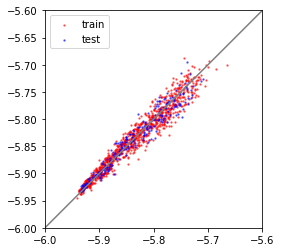

In [16]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
model.eval()
with torch.no_grad():
    predict=torch.sum(model(X_test),dim=1)/64.0
    train=torch.sum(model(X_train),dim=1)/64.0
    plt.gca().set_aspect('equal')
    min=-6
    max=-5.6
    plt.xlim((min,max))
    plt.ylim((min,max))
    plt.plot([min,max],[min,max],color='gray')
    
    plt.scatter(y_train,train,c='red',s=2,alpha=0.5,label='train')
    plt.scatter(y_test,predict,c='blue',s=2,alpha=0.5,label='test')
    plt.legend()

In [17]:
diff=(y_test-predict.to('cpu').detach().numpy()).numpy()
RMSE=np.sqrt(np.mean(np.abs(diff)*np.abs(diff)))
print('RMSE={0:f} eV/atom'.format(RMSE))

RMSE=0.013832 eV/atom


そこまで外れてはいませんが、もうちょい精度が欲しいという感じですね。
精度を上げるには、一つにはデータ数を増やすこと、もう一つは対称性関数のハイパーパラメータを調整したり数を増やすこと、あと、学習でのハイパーパラメータを調整することが挙げられます。


It is not that far off, but I would like to see a little more accuracy.
One way to increase accuracy is to increase the number of data, another is to adjust the hyperparameters of the symmetry function and increase the number of data, and another is to adjust the hyperparameters in the training.